In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from pathlib import Path
from itertools import product
import re       

In [1]:
!pip install corner

In [47]:
"""
Make a helper function that extracts the n-th number from a string
"""
def extract_nth_number(s, n):
    numbers = re.findall(r'\d+', s)
    if 0 < n <= len(numbers):
        return int(numbers[n - 1])
    else:
        return None

In [63]:
""" 
Import all report cards

"""

# Path to the report cards
bids_root = '../report_cards/'
bids_root = str(Path.home()) + '/Documents/muniverse-data/report_cards_pm/'

# List of datasetnames
# datasetnames = ['Caillet_et_al_2023', 'Grison_et_al_2025', 'Avrillon_et_al_2024', 'hybrid_tibialis', 'neuromotion_test']
datasetnames = ['hybrid_tibialis', 'neuromotion_test']

# List of algorithm names
pipelinenames = ['cbss', 'scd']
pipelinenames = ['cbss', 'upperbound']
pipelinenames = ['cbss', 'scd', 'upperbound']

# Make an empty template of a report card dictonary
global_rc = {pipeline: pd.DataFrame() for pipeline in pipelinenames}
source_rc = {pipeline: pd.DataFrame() for pipeline in pipelinenames}

# Read in report cards
for dataset in datasetnames:
    for pipeline in pipelinenames:
        path = bids_root + dataset + '-' + pipeline + '/'
        dataset_global_rc = pd.read_csv(path + 'report_card_globals.tsv', delimiter='\t')
        dataset_source_rc = pd.read_csv(path + 'report_card_sources.tsv', delimiter='\t')
        global_rc[pipeline] = pd.concat([global_rc[pipeline], dataset_global_rc], ignore_index=True)
        source_rc[pipeline] = pd.concat([source_rc[pipeline], dataset_source_rc], ignore_index=True)

In [ ]:
# It seems that the only thing we really care about here is the explained variance

# From the other table, we get
# SIL, PNR, NSPIKES, 
source_rc['upperbound']

In [64]:
""" 
Extract some global metrics from some dataset of interest

"""

# dataset_of_interest = ['neuromotion-test']
dataset_of_interest = ['hybrid-tibialis']
#dataset_of_interest = ['Caillet_et_al_2023', 'Grison_et_al_2025', 'Avrillon_et_al_2024']
#dataset_of_interest = ['Caillet_et_al_2023', 'Grison_et_al_2025', 'hybrid-tibialis', 'neuromotion-test']

task_keys = ['isometric', 'trapezoid']
# task_keys = []

rows = [f"{d}-{a}" for d, a in product(dataset_of_interest, pipelinenames)]
columns = ['n_source_10', 'n_source_50', 'n_source_90', 
           'exp_var_10', 'exp_var_50', 'exp_var_90',
           'runtime_10', 'runtime_50', 'runtime_90']
summary = pd.DataFrame(np.nan, index=rows, columns=columns) 

sil_th = 0.87
min_num_spikes = 30
mvc_threshold = 100

for dataset in dataset_of_interest:
    for pipeline in pipelinenames:
        # Get a unqiue identifier, i.e., dataset-pipeline
        row = f"{dataset}-{pipeline}"
        
        # Make a copy of the global data frame
        gdf = global_rc[pipeline].copy()
        # Only keep entries belonging to the current dataset
        gdf = gdf[(gdf['datasetname'] == dataset)]
        # Make sure the explained variance is in [0 1]
        gdf['explained_var'] = gdf['explained_var'].clip(lower=0, upper=1)
        # Focus on specific tasks and mvc level
        for task_key in task_keys:
            gdf = gdf[gdf['filename'].str.contains(task_key, case=False, na=False)]
        # Extract the MVC level from the file name and filter by intensity
        if dataset=='neuromotion-test':
            mvc_num = 3
        else:
            mvc_num = 2
        gdf['mvc'] = gdf['filename'].apply(lambda x: extract_nth_number(x, mvc_num))    
        gdf = gdf[(gdf['mvc'] < mvc_threshold)]
        
        # Make a copy of the source report card
        sdf = source_rc[pipeline].copy()
        # Only keep entries belonging to the current dataset
        sdf = sdf[(sdf['datasetname'] == dataset)]
        # Focus on specific tasks and mvc level
        for task_key in task_keys:
            sdf = sdf[sdf['filename'].str.contains(task_key, case=False, na=False)]
        # Extract the MVC level from the file name and filter by intensity
        sdf['mvc'] = sdf['filename'].apply(lambda x: extract_nth_number(x, mvc_num))    
        sdf = sdf[(sdf['mvc'] < mvc_threshold)]

        # List all filenames that are left to analyze and loop around them   
        files = list(gdf['filename'])
        n_sources = np.zeros(len(files))
        for idx, file in enumerate(files):
            # Make a copy of your source datafile 
            ssdf = sdf.copy()
            # Only keep sources that belong to the current file and fullfile some quality checks
            ssdf = sdf[(sdf['filename'] == file) & 
                       (sdf['sil'] > sil_th) & 
                       (sdf['n_spikes'] > min_num_spikes)]
            n_sources[idx] = ssdf.shape[0]

        # Get the 10th, 50th and 90th percentile of the number of extracted sources
        summary.loc[row, 'n_source_50'] = np.round(np.percentile(n_sources,50) ,2)
        summary.loc[row, 'n_source_10'] = np.round(np.percentile(n_sources,10), 2)
        summary.loc[row, 'n_source_90'] = np.round(np.percentile(n_sources,90), 2)   
        # Get the 10th, 50th and 90th percentile of the runtimes
        summary.loc[row, 'runtime_50'] = np.round(np.percentile(gdf['runtime'],50), 0)
        summary.loc[row, 'runtime_10'] = np.round(np.percentile(gdf['runtime'],10), 0)
        summary.loc[row, 'runtime_90'] = np.round(np.percentile(gdf['runtime'],90), 0)
        # Get the 10th, 50th and 90th percentile of the explained variance
        summary.loc[row, 'exp_var_50'] = np.round(np.percentile(gdf['explained_var'],50), 2)
        summary.loc[row, 'exp_var_10'] = np.round(np.percentile(gdf['explained_var'],10), 2)
        summary.loc[row, 'exp_var_90'] = np.round(np.percentile(gdf['explained_var'],90), 2) 

print(summary)          


/var/folders/4t/bwrv63q120sc9gq1l440kc_40000gn/T/ipykernel_42478/683311259.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdf['explained_var'] = gdf['explained_var'].clip(lower=0, upper=1)


KeyboardInterrupt: 

In [1]:
"""
Do spike matching for some dataset of interest

"""

# Dataset of interest
#dataset_of_interest = ['Grison_et_al_2025']
dataset_of_interest = ['neuromotion-test', 'hybrid-tibialis']
#dataset_of_interest = ['hybrid-tibialis']
# Pipelines to be analyzed
# pipelinenames = ['cbss', 'scd']
pipelinenames = ['cbss', 'scd','upperbound']

filt_source_rc = {pipeline: pd.DataFrame() for pipeline in pipelinenames}

# Make an empty data frame
rows = [f"{d}-{a}" for d, a in product(dataset_of_interest, pipelinenames)]
columns = ['n_source', 'n_rel', 
           'roa_10', 'roa_50', 'roa_90', 
           'precision_10', 'precision_50', 'precision_90',
           'sensitivity_10', 'sensitivity_50', 'sensitivity_90',
           'F1_10', 'F1_50', 'F1_90' 
           ]
summary = pd.DataFrame(np.nan, index=rows, columns=columns) 

# Select specific tasks
task_keys = []
# task_keys = ['isometric', 'trapezoid']
# Filter by mvc level
mvc_threshold = 100
sil_th = 0
match_th = 0.5

for dataset in dataset_of_interest:
    for pipeline in pipelinenames:
        # Get a unqiue identifier, i.e., dataset-pipeline
        row = f"{dataset}-{pipeline}"
        
        # Make a copy of the global data frame
        gdf = global_rc[pipeline].copy()
        # Only keep entries belonging to the current dataset
        gdf = gdf[(gdf['datasetname'] == dataset)]
        # Make sure the explained variance is in [0 1]
        gdf['explained_var'] = gdf['explained_var'].clip(lower=0, upper=1)
        # Focus on specific tasks and mvc level
        for task_key in task_keys:
            gdf = gdf[gdf['filename'].str.contains(task_key, case=False, na=False)]
        # Extract the MVC level from the file name and filter by intensity
        if dataset=='neuromotion-test':
            mvc_num = 3
        else:
            mvc_num = 2
        gdf['mvc'] = gdf['filename'].apply(lambda x: extract_nth_number(x, mvc_num))    
        gdf = gdf[(gdf['mvc'] < mvc_threshold)]

        # Make a copy of the source report card
        sdf = source_rc[pipeline].copy()
        # Only keep entries belonging to the current dataset
        sdf = sdf[(sdf['datasetname'] == dataset)]
        # Focus on specific tasks and mvc level
        for task_key in task_keys:
            sdf = sdf[sdf['filename'].str.contains(task_key, case=False, na=False)]
        # Extract the MVC level from the file name and filter by intensity
        sdf['mvc'] = sdf['filename'].apply(lambda x: extract_nth_number(x, mvc_num))    
        sdf = sdf[(sdf['mvc'] < mvc_threshold)]
        # Only keep sources that belong to the current file and fullfile some quality checks
        sdf = sdf[(sdf['sil'] > sil_th)]
        
        # Get the total number of sources
        n_total = int(sdf.shape[0])
        # Get the number of matched sources
        sdf = sdf[(sdf['TP'] > 1)]
        # Compute the rate of agreement
        sdf['RoA'] = sdf['TP'] / (sdf['TP'] + sdf['FP'] + sdf['FN'])
        # Compute the precision
        sdf['Precision'] = sdf['TP'] / (sdf['TP'] + sdf['FP'])
        # Compute the recall
        sdf['Recall'] = sdf['TP'] / (sdf['TP'] + sdf['FN'])
        # Calculate the F1 score
        sdf['F1'] = 2*sdf['Precision']*sdf['Recall']/ (sdf['Precision'] + sdf['Recall'])

        sdf = sdf[(sdf['Recall']>match_th)]

        filt_source_rc[pipeline] = pd.concat([filt_source_rc[pipeline], sdf], ignore_index=True)

        # Get both total and relative number of matched sources
        summary.loc[row, 'n_source'] = int(sdf.shape[0])
        if n_total > 0:
            summary.loc[row, 'n_rel'] = int(sdf.shape[0]) / n_total 
        else:
            summary.loc[row, 'n_rel'] = 0
        # Get the 10th, 50th and 90th percentile of the RoA
        summary.loc[row, 'roa_10'] = np.round(np.percentile(sdf['RoA'],10),2)
        summary.loc[row, 'roa_50'] = np.round(np.percentile(sdf['RoA'],50),2)
        summary.loc[row, 'roa_90'] = np.round(np.percentile(sdf['RoA'],90),2)
        # Get the 10th, 50th and 90th percentile of the Precision
        summary.loc[row, 'precision_10'] = np.round(np.percentile(sdf['Precision'],10),2)
        summary.loc[row, 'precision_50'] = np.round(np.percentile(sdf['Precision'],50),2)
        summary.loc[row, 'precision_90'] = np.round(np.percentile(sdf['Precision'],90),2)
        # Get the 10th, 50th and 90th percentile of the Recall
        summary.loc[row, 'sensitivity_10'] = np.round(np.percentile(sdf['Recall'],10),2)
        summary.loc[row, 'sensitivity_50'] = np.round(np.percentile(sdf['Recall'],50),2)
        summary.loc[row, 'sensitivity_90'] = np.round(np.percentile(sdf['Recall'],90),2)
        # Get the 10th, 50th and 90th percentile of the F1 score
        summary.loc[row, 'F1_10'] = np.round(np.percentile(sdf['F1'], 10),2)
        summary.loc[row, 'F1_50'] = np.round(np.percentile(sdf['F1'], 50),2)
        summary.loc[row, 'F1_90'] = np.round(np.percentile(sdf['F1'], 90),2) 



print(summary)          


NameError: name 'pd' is not defined

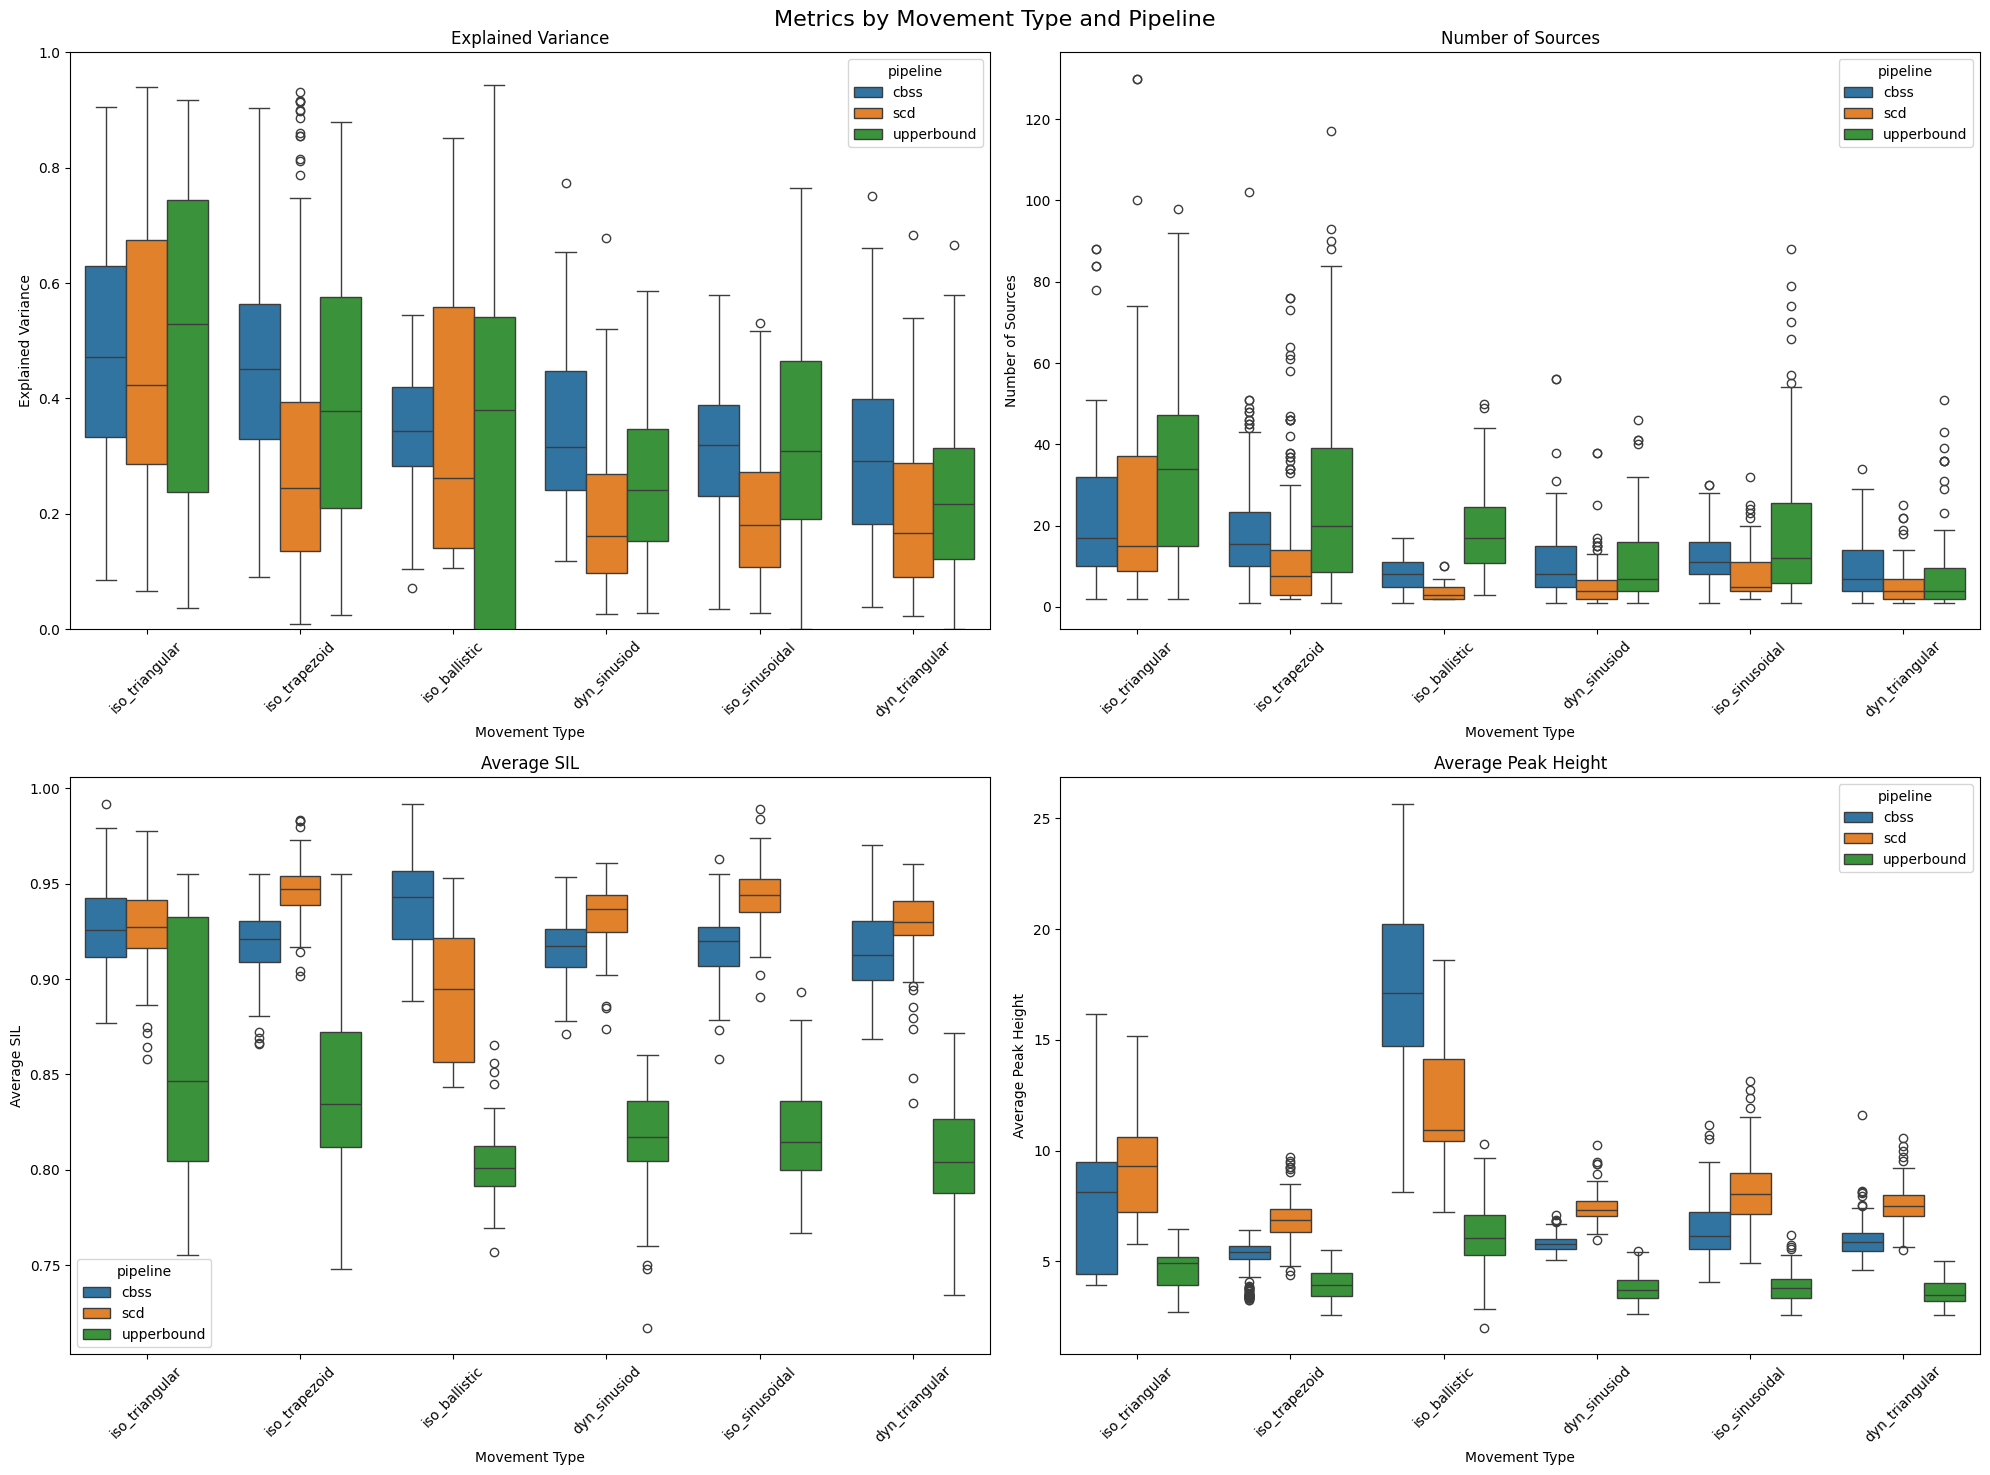


Summary Statistics by Movement Type and Pipeline:
                          explained_var               n_sources          \
                                   mean           std      mean     std   
movement_type  pipeline                                                   
dyn_sinusiod   cbss        3.440000e-01  1.380000e-01    11.015   9.001   
               scd         2.040000e-01  1.400000e-01     6.149   6.449   
               upperbound  2.570000e-01  1.340000e-01    11.379   9.959   
dyn_triangular cbss        3.040000e-01  1.570000e-01     9.109   6.555   
               scd         2.050000e-01  1.400000e-01     5.562   5.099   
               upperbound  2.350000e-01  1.490000e-01     7.968  10.265   
iso_ballistic  cbss        3.350000e-01  1.010000e-01     8.231   3.972   
               scd         3.560000e-01  2.460000e-01     4.190   2.562   
               upperbound -2.940093e+74  2.120131e+75    19.173  11.749   
iso_sinusoidal cbss        3.060000e-01  1.040000

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Function to extract movement type from filename
def extract_movement_type(filename):
    filename = filename.lower()
    if 'isometric' in filename and 'trapezoid' in filename:
        return 'iso_trapezoid'
    elif 'isometric' in filename and 'triangular' in filename:
        return 'iso_triangular'
    elif 'isometric' in filename and 'sinusoid' in filename:
        return 'iso_sinusoidal'
    elif 'isometric' in filename and 'ballistic' in filename:
        return 'iso_ballistic'
    elif 'dynamic' in filename and 'sinusoid' in filename:
        return 'dyn_sinusiod'
    elif 'dynamic' in filename and 'triangular' in filename:
        return 'dyn_triangular'
    else:
        return 'other'

# Quality thresholds
sil_th = 0.87
min_num_spikes = 1
match_th = 0.5

# Create a new dataframe with the metrics we want to analyze
metrics_df = pd.DataFrame()

for pipeline in pipelinenames:
    # Get global metrics
    gdf = global_rc[pipeline].copy()
    gdf['movement_type'] = gdf['filename'].apply(extract_movement_type)
    gdf['pipeline'] = pipeline
    
    # Get source metrics
    sdf = source_rc[pipeline].copy()
    sdf['Recall'] = sdf['TP'] / (sdf['TP'] + sdf['FN'])
    sdf['movement_type'] = sdf['filename'].apply(extract_movement_type)
    sdf = sdf[(sdf['Recall'] > match_th)]
    
    # Calculate number of sources per file that meet quality criteria
    n_sources = []
    for file in gdf['filename']:
        ssdf = sdf[(sdf['filename'] == file) & 
                  #(sdf['sil'] > sil_th) & 
                  (sdf['Recall'] > match_th) & 
                  (sdf['n_spikes'] > min_num_spikes)]
        n_sources.append(ssdf.shape[0])
    
    gdf['n_sources'] = n_sources
    
    # Calculate average SIL and peak height per file
    avg_metrics = sdf.groupby('filename').agg({
        'sil': 'mean',
        'peak_height': 'mean',
        'movement_type': 'first'
    }).reset_index()
    
    # Merge with global metrics
    merged_df = pd.merge(gdf, avg_metrics, on=['filename', 'movement_type'])
    
    # Select and rename columns
    metrics_df = pd.concat([metrics_df, merged_df[['pipeline', 'movement_type', 
                                                  'explained_var', 'n_sources',
                                                  'sil', 'peak_height']]])

# Create subplots for each metric
fig, axes = plt.subplots(2, 2, figsize=(20, 15))  # Made figure larger to accommodate more categories
fig.suptitle('Metrics by Movement Type and Pipeline', fontsize=16)

# Plot explained variance
sns.boxplot(data=metrics_df, x='movement_type', y='explained_var', hue='pipeline', ax=axes[0,0])
axes[0,0].set_title('Explained Variance')
axes[0,0].set_xlabel('Movement Type')
axes[0,0].set_ylabel('Explained Variance')
axes[0,0].tick_params(axis='x', rotation=45)  # Rotate x-axis labels for better readability
axes[0,0].set_ylim(0,1)

# Plot number of sources
sns.boxplot(data=metrics_df, x='movement_type', y='n_sources', hue='pipeline', ax=axes[0,1])
axes[0,1].set_title('Number of Sources')
axes[0,1].set_xlabel('Movement Type')
axes[0,1].set_ylabel('Number of Sources')
axes[0,1].tick_params(axis='x', rotation=45)

# Plot average SIL
sns.boxplot(data=metrics_df, x='movement_type', y='sil', hue='pipeline', ax=axes[1,0])
axes[1,0].set_title('Average SIL')
axes[1,0].set_xlabel('Movement Type')
axes[1,0].set_ylabel('Average SIL')
axes[1,0].tick_params(axis='x', rotation=45)

# Plot average peak height
sns.boxplot(data=metrics_df, x='movement_type', y='peak_height', hue='pipeline', ax=axes[1,1])
axes[1,1].set_title('Average Peak Height')
axes[1,1].set_xlabel('Movement Type')
axes[1,1].set_ylabel('Average Peak Height')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary Statistics by Movement Type and Pipeline:")
summary = metrics_df.groupby(['movement_type', 'pipeline']).agg({
    'explained_var': ['mean', 'std'],
    'n_sources': ['mean', 'std'],
    'sil': ['mean', 'std'],
    'peak_height': ['mean', 'std']
}).round(3)
print(summary)

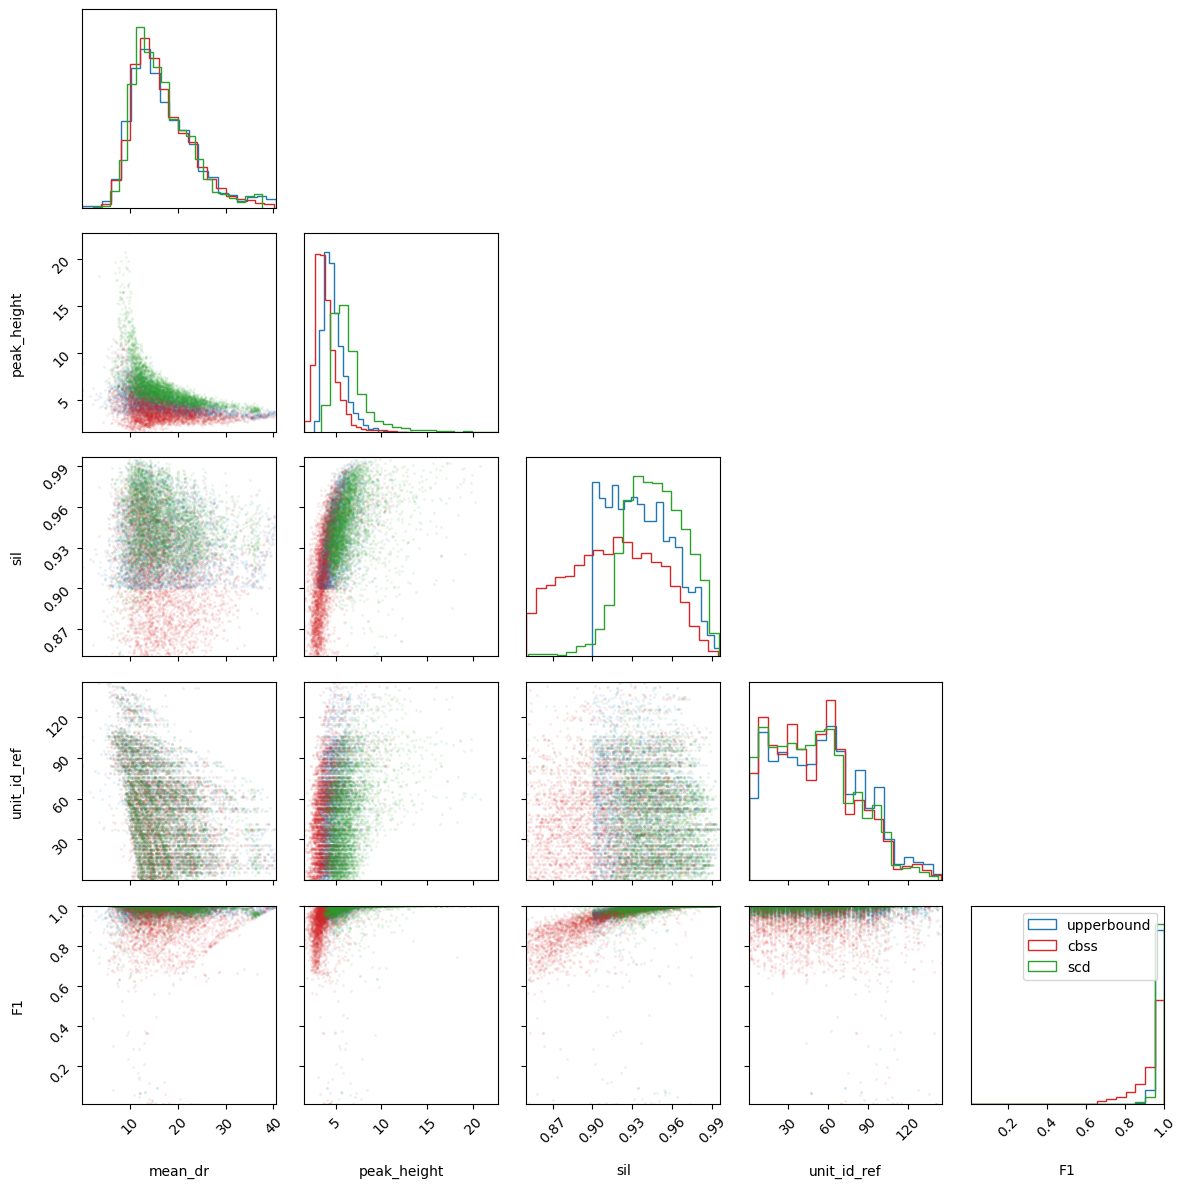

In [26]:
import seaborn as sns
import corner
import numpy as np
import matplotlib.pyplot as plt

# Prepare the data
sdf1 = filt_source_rc['upperbound']
sdf2 = filt_source_rc['cbss']
sdf3 = filt_source_rc['scd']

# Variables to plot
variables = ['mean_dr', 'peak_height', 'sil', 'unit_id_ref', 'F1']

# Create figure
fig = plt.figure(figsize=(12, 12))

# Plot each algorithm with a different color
colors = ['C0', 'C3', 'C2']
algorithms = ['upperbound', 'cbss', 'scd']
datasets = [sdf1, sdf2, sdf3]

# First plot to set up the corner plot
corner.corner(datasets[0][variables].values,
             labels=variables,
             color=colors[0],
             alpha=0.8,
             hist_kwargs={'density': True},
             fig=fig,
             plot_density=False,
             plot_contours=False,
             plot_datapoints=True,
             markersize=4)

# Overlay the other datasets
for data, color, label in zip(datasets[1:], colors[1:], algorithms[1:]):
    corner.corner(data[variables].values,
                 color=color,
                 alpha=0.8,
                 hist_kwargs={'density': True},
                 fig=fig,
                 plot_density=False,
                 plot_contours=False,
                 plot_datapoints=True,
                 markersize=4)

# Add legend
plt.legend(algorithms, loc='upper right', bbox_to_anchor=(1.0, 1.0))

plt.tight_layout()
plt.show()

In [86]:
from collections import Counter

sdf1 = filt_source_rc['upperbound']
sdf2 = filt_source_rc['cbss']
sdf3 = filt_source_rc['scd']

sdf1['alg'] = 'upperbound'
sdf2['alg'] = 'cbss'
sdf3['alg'] =  'scd'
df = pd.concat([sdf1, sdf2, sdf3], ignore_index=True)
df['movement_type'] = sdf['filename'].apply(extract_movement_type)
df['file_id'] = df['datasetname'].astype(str) + '::' + df['filename'] + '::' + df['unit_id_ref'].astype(str)


In [ ]:
#dataset = 'neuromotion-test'
#dataset = 'hybrid-tibialis'
ta_df = df[(df['datasetname'] == 'hybrid-tibialis')]
nm_df = df[(df['datasetname'] == 'neuromotion-test')]

desired_order = [
    ('cbss',),
    ('scd',),
    ('upperbound',),
    ('cbss', 'scd'),
    ('cbss', 'upperbound'),
    ('scd', 'upperbound'),
    ('cbss', 'scd', 'upperbound')
]


file_class_map = ta_df.groupby('file_id')['alg'].apply(set)
pattern_counts_ta = Counter(tuple(sorted(classes)) for classes in file_class_map)

labels_ta = []
sizes_ta = []

for pattern in desired_order:
    count = pattern_counts_ta.get(pattern, 0)
    label = '+'.join(pattern)
    labels_ta.append(label)
    sizes_ta.append(count)

file_class_map = nm_df.groupby('file_id')['alg'].apply(set)
pattern_counts_nm = Counter(tuple(sorted(classes)) for classes in file_class_map)

labels_nm = []
sizes_nm = []

for pattern in desired_order:
    count = pattern_counts_nm.get(pattern, 0)
    label = '+'.join(pattern)
    labels_nm.append(label)
    sizes_nm.append(count)    

fig11, axes11 = plt.subplots(1, 2, figsize=(20, 15)) 

axes11[0].pie(sizes_ta, labels=labels_ta, autopct='%1.1f%%', startangle=90)
axes11[0].set_title('Hybrid tibialis')
axes11[1].pie(sizes_nm, labels=labels_nm, autopct='%1.1f%%', startangle=90)
axes11[1].set_title('Neuromotion test')

# plt.figure(figsize=(6, 6))
# plt.pie(sizes_ta, labels=labels_ta, autopct='%1.1f%%', startangle=90)
# plt.title("File occurrence across classes")
# plt.axis('equal')
# plt.show()